# Network topology evaluation of adjacencies calculated from expression data
**Authorship:** Adam Klie (last updated: 08/09/2023)<br>
***
**Description:** This notebook takes in any adjacencies calculated on the Parse sequencing of the `igvf_b01_LeftCortex` dataset and uses CellOracle functions to evaluate the network topology of the adjacencies. 
***

# Set-up

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [344]:
# CellOracle and Decoupler
import celloracle as co
import decoupler as dc
from igraph import Graph
from scipy import sparse
co.__version__

'0.14.0'

In [101]:
from celloracle.network_analysis.links_object import _thresholding
from sklearn.linear_model import LinearRegression as lr

def read_links_dict_from_metadata(metadata_df, verbose=True, make_celloracle_compatible=False):
    links_dict = {}
    for _, row in metadata_df.iterrows():
        name = f"{row['method']}_{row['cells']}_{row['genotype']}_{row['genes']}_{row['normalization']}"
        links_file = row["output_table_path"]
        links_df = pd.read_csv(links_file, sep="\t")
        links_dict[name] = links_df
        if verbose:
            print(f"Finished reading {name} that has {len(links_df)} links")
    return links_dict

def filter_links_dict(links_dict, p=None, weight="weight_unsigned", threshold_number=2000, verbose=True):
    filtered_links_dict = {}
    for name, links_df in links_dict.items():
        filtered_links_df = _thresholding(links_df, p=p, weight=weight, threshold_number=threshold_number)
        if verbose:
            print(f"{name} went from {len(links_df)} to {len(filtered_links_df)}")
        if len(filtered_links_df) < 2000:
            print(f"The number of links in {name} is less than 2000. Need to add small value to weight_minmax_normalized.")
            filtered_links_df["weight_minmax_normalized"] = filtered_links_df["weight_minmax_normalized"] + 1e-8
        filtered_links_dict[name] = filtered_links_df
    return filtered_links_dict
    
def create_igraph_from_links(links):
    g = Graph.DataFrame(links[["source", "target"]], directed=True, use_vids=False)
    # check if any of the weight_minmax_normalized is negative
    if links["weight_minmax_normalized"].min() < 0:
        print("Negative value detected in weight_minmax_normalized.")
        #links["weight_minmax_normalized"] = links["weight_minmax_normalized"] + 1
    g.es["weight"] = links["weight_minmax_normalized"].values.copy()
    return g

def node_scores(g):
    df = g.get_vertex_dataframe()
    for i in ["all", "in", "out"]:
        df[f"degree_{i}"] = g.degree(mode=i)
        df[f"degree_centrality_{i}"] = df[f"degree_{i}"] / (df.shape[0]-1)
    df["betweenness_centrality"] = g.betweenness(directed=True, weights="weight")
    df["eigenvector_centrality"] = g.eigenvector_centrality(directed=False, weights="weight")
    df = df.set_index("name")
    df.index.name = None
    return df

def node_scores_from_links_dict(links_dict, verbose=True):
    node_scores_lst = []
    for name, links in links_dict.items():
        
        g = create_igraph_from_links(links)
        df = node_scores(g)
        df["run_name"] = name
        node_scores_lst.append(df)
    return pd.concat(node_scores_lst, axis=0)

In [128]:
metadata_dir = "/cellar/users/aklie/projects/igvf/topic_grn_links/eval/metadata/"
dataset_name = "igvf_b01_LeftCortex"
in_date = "01Sep23"

# Load metadata file

In [129]:
# Read in all the networks
metadata_df = pd.read_csv(os.path.join(metadata_dir, dataset_name, in_date, "eval_metadata.tsv"), sep="\t")
len(metadata_df)

48

In [ ]:
metadata_df["run_name"] = metadata_df["method"] + "_" + metadata_df["cells"] + "_" + metadata_df["genotype"] + "_" + metadata_df["genes"].astype(str) + "_" + metadata_df["normalization"]


In [95]:
# Read in all the links
links_dict = read_links_dict_from_metadata(metadata_df, verbose=False)

In [96]:
# Threshold the links
filtered_links_dict = filter_links_dict(links_dict, p=None, weight="weight_unsigned", threshold_number=2000, verbose=False)

The number of links in aracne_balanced_genotype_microglia_CASTJ_0.05_raw is less than 2000. Need to add small value to weight_minmax_normalized.


# Get node scores

In [117]:
merged_node_scores = node_scores_from_links_dict(filtered_links_dict, verbose=False)

# Create rankings for each run

## Node scores

In [135]:
metrics = ["degree_all", "degree_in", "degree_out", "degree_centrality_all", "degree_centrality_in", "degree_centrality_out", "betweenness_centrality", "eigenvector_centrality"]
for run, df, in merged_node_scores.groupby("run_name"):
    if not os.path.exists(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", run)):
        os.makedirs(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", run))
    links_df = filtered_links_dict[run]
    run_tfs = links_df["source"].unique()
    df = df.loc[run_tfs, :]
    for metric in metrics:
        curr_df = df[[metric]].copy()
        curr_df["rank"] = curr_df[metric].rank(ascending=False)
        curr_df = curr_df.sort_values("rank")
        curr_df.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", run, f"{metric}.tsv"), sep="\t")

# TF activity scores

In [295]:
run = "aracne_balanced_genotype_microglia_B6J_0.05_log1p_cp10k"

In [297]:
tf_list = pd.read_csv("/cellar/users/aklie/opt/igvf-ucsd/scenic_pipeline/data/tf_lists/allTFs_mm.txt", header=None)[0].values
tf_list[:5]

array(['Bcl6b', 'Zscan26', 'Mtf1', 'Klf9', 'Zic5'], dtype=object)

## Baseline 1 expression

In [342]:
tf_adata_ranked

,gene_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mean_expression,rank
gene,,,,,,,,,
Zfhx3,ENSMUSG00000038872.11,16798,False,16798,0.661964,78.156047,50905.0,3.472222,1.0
Mef2a,ENSMUSG00000030557.18,46178,False,46178,1.361586,39.950585,104706.0,2.930763,2.0
Zeb2,ENSMUSG00000026872.19,52895,False,52895,3.310546,31.215865,254581.0,2.404644,3.0
Mef2c,ENSMUSG00000005583.17,47639,False,47639,4.845657,38.050715,372631.0,2.384328,4.0
Foxn3,ENSMUSG00000033713.13,43808,False,43808,1.247269,43.032510,95915.0,2.005390,5.0
...,...,...,...,...,...,...,...,...,...
Ash2l,ENSMUSG00000031575.19,11144,False,11144,0.169051,85.508453,13000.0,0.054726,393.0
Zfp131,ENSMUSG00000094870.9,13447,False,13447,0.215761,82.513654,16592.0,0.053897,394.0
Lyl1,ENSMUSG00000034041.6,252,False,252,0.003342,99.672302,257.0,0.053483,395.0


In [347]:
for i, row in metadata_df.iterrows():
    
    # Read in the adata
    h5ad_file = row["in_file_path"].replace(".tsv", ".h5ad").replace(".loom", ".h5ad")
    adata = sc.read_h5ad(h5ad_file)

    # Get the run name
    run = row["cells"] + "_" + row["genotype"] + "_" + str(row["genes"]) + "_" + row["normalization"]

    # Intersect with tf list
    tfs_in_adata = np.intersect1d(tf_list, adata.var_names)
    tf_adata = adata[:, tfs_in_adata].copy()

    # Rank the TFs in the list by expression level in the tf_adata
    tf_adata.var["mean_expression"] = tf_adata.X.A.mean(axis=0)
    tf_adata.var["rank"] = tf_adata.var["mean_expression"].rank(ascending=False)
    tf_adata_ranked = tf_adata.var.sort_values("rank")

    # Clean up
    tf_adata_ranked = tf_adata_ranked[["mean_expression", "rank"]]
    tf_adata_ranked.index.name = None
    
    # Save the ranked TFs
    tf_adata_ranked.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", "baselines", f"{run}_expression_rank.tsv"), sep="\t")

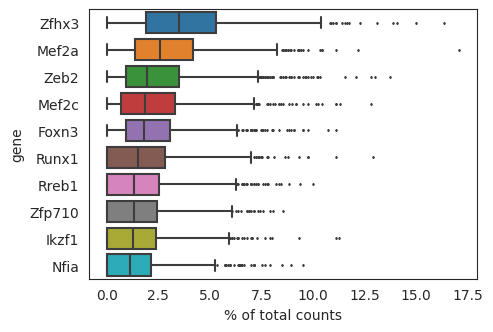

In [299]:
sc.pl.highest_expr_genes(tf_adata, n_top=10)

## Baseline 2 generic network

In [345]:
net = dc.get_dorothea(organism='mouse', split_complexes=False)
net

,source,confidence,target,weight
0,Myc,A,Tert,1.0
1,Myc,A,Cct5,1.0
2,Myc,A,Gnl3,1.0
3,Myc,A,Nol7,1.0
4,Myc,A,Dpy30,1.0
...,...,...,...,...
2800,Jun,A,Myb,1.0
2801,Jund,A,Myb,1.0
2802,Lhx3,A,Fshb,1.0
2803,Usf1,A,Hmox1,1.0


In [ ]:
for i, row in metadata_df.iterrows():
    
    # Read in the adata
    h5ad_file = row["in_file_path"].replace(".tsv", ".h5ad").replace(".loom", ".h5ad")
    adata = sc.read_h5ad(h5ad_file)

    # Get the run name
    run = row["cells"] + "_" + row["genotype"] + "_" + str(row["genes"]) + "_" + row["normalization"]

    # Make sure the adata uses the normalized counts
    adata.raw = adata.copy()
    if sparse.issparse(adata.layers["normalized_counts"]):
        adata.X = adata.layers["normalized_counts"].A
    else:
        adata.X = adata.layers["normalized_counts"]

    # Run decoupler with ULM
    dc.run_ulm(
        mat=adata,
        net=net,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False
    )

    # Grab the ULM estimates
    acts = dc.get_acts(adata, obsm_key='ulm_estimate')
    acts.var["mean_activity"] = acts.X.mean(axis=0)
    acts.var["rank"] = acts.var["mean_activity"].rank(ascending=False)
    acts_ranked = acts.var.sort_values("rank")

    # Clean up
    acts_ranked = acts_ranked[["mean_activity", "rank"]]
    acts_ranked.index.name = None

    # Save the ranked TFs
    acts_ranked.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", "baselines", f"{run}_dorothea_ulm_rank.tsv"), sep="\t")

    # Run decoupler with VIPER
    dc.run_viper(
        mat=adata,
        net=net,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False
    )

    # Grab the VIPER estimates
    acts = dc.get_acts(adata, obsm_key='viper_estimate')
    acts.var["mean_activity"] = acts.X.mean(axis=0)
    acts.var["rank"] = acts.var["mean_activity"].rank(ascending=False)
    acts_ranked = acts.var.sort_values("rank")

    # Clean up
    acts_ranked = acts_ranked[["mean_activity", "rank"]]
    acts_ranked.index.name = None

    # Save the ranked TFs
    acts_ranked.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", "baselines", f"{run}_dorothea_viper_rank.tsv"), sep="\t")

    # Run decoupler with AUCell
    dc.run_aucell(
        mat=adata,
        net=net,
        source='source',
        target='target',
        verbose=True,
        use_raw=False
    )

    # Grab the AUCell estimates
    acts = dc.get_acts(adata, obsm_key='aucell_estimate')
    acts.var["mean_activity"] = acts.X.mean(axis=0)
    acts.var["rank"] = acts.var["mean_activity"].rank(ascending=False)
    acts_ranked = acts.var.sort_values("rank")

    # Clean up
    acts_ranked = acts_ranked[["mean_activity", "rank"]]
    acts_ranked.index.name = None

    # Save the ranked TFs
    acts_ranked.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", "baselines", f"{run}_dorothea_aucell_rank.tsv"), sep="\t")
break

# Run specific network

In [354]:
for i, row in metadata_df.iterrows():
    
    # Read in the adata
    h5ad_file = row["in_file_path"].replace(".tsv", ".h5ad").replace(".loom", ".h5ad")
    adata = sc.read_h5ad(h5ad_file)

    # Get the run name for outputting to
    run = row["run_name"]
    print(run)

    # Get the run specific GRN
    grn = filtered_links_dict[run]

    # Make sure the adata uses the normalized counts
    adata.raw = adata.copy()
    if sparse.issparse(adata.layers["normalized_counts"]):
        adata.X = adata.layers["normalized_counts"].A
    else:
        adata.X = adata.layers["normalized_counts"]

    # Run decoupler with ULM
    dc.run_ulm(
        mat=adata,
        net=grn,
        source='source',
        target='target',
        weight='weight_minmax_normalized',
        verbose=True,
        use_raw=False
    )

    # Grab the ULM estimates
    acts = dc.get_acts(adata, obsm_key='ulm_estimate')
    acts.var["mean_activity"] = acts.X.mean(axis=0)
    acts.var["rank"] = acts.var["mean_activity"].rank(ascending=False)
    acts_ranked = acts.var.sort_values("rank")

    # Clean up
    acts_ranked = acts_ranked[["mean_activity", "rank"]]
    acts_ranked.index.name = None

    # Save the ranked TFs
    acts_ranked.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", run, f"ulm.tsv"), sep="\t")

    # Run decoupler with VIPER
    dc.run_viper(
        mat=adata,
        net=grn,
        source='source',
        target='target',
        weight='weight_minmax_normalized',
        verbose=True,
        use_raw=False
    )

    # Grab the VIPER estimates
    acts = dc.get_acts(adata, obsm_key='viper_estimate')
    acts.var["mean_activity"] = acts.X.mean(axis=0)
    acts.var["rank"] = acts.var["mean_activity"].rank(ascending=False)
    acts_ranked = acts.var.sort_values("rank")

    # Clean up
    acts_ranked = acts_ranked[["mean_activity", "rank"]]
    acts_ranked.index.name = None

    # Save the ranked TFs
    acts_ranked.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", run, f"viper.tsv"), sep="\t")

    # Run decoupler with AUCell
    dc.run_aucell(
        mat=adata,
        net=grn,
        source='source',
        target='target',
        verbose=True,
        use_raw=False
    )

    # Grab the AUCell estimates
    acts = dc.get_acts(adata, obsm_key='aucell_estimate')
    acts.var["mean_activity"] = acts.X.mean(axis=0)
    acts.var["rank"] = acts.var["mean_activity"].rank(ascending=False)
    acts_ranked = acts.var.sort_values("rank")

    # Clean up
    acts_ranked = acts_ranked[["mean_activity", "rank"]]
    acts_ranked.index.name = None

    # Save the ranked TFs
    acts_ranked.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", run, f"aucell.tsv"), sep="\t")

aracne_balanced_genotype_microglia_B6J_0.05_raw
1 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4076 targets for 53 sources.
1 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4076 targets for 53 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [00:10<00:00, 114.25it/s]


1 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4076 targets for 53 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1535.94it/s]


aracne_balanced_genotype_microglia_CASTJ_0.05_raw
2 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4075 targets for 81 sources.
2 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4075 targets for 81 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [00:24<00:00, 49.26it/s]


2 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4075 targets for 81 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1346.05it/s]


aracne_balanced_genotype_microglia_both_0.05_raw
Running ulm on mat with 2412 samples and 4077 targets for 48 sources.
Running viper on mat with 2412 samples and 4077 targets for 48 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 2412/2412 [00:28<00:00, 83.26it/s] 


Running aucell on mat with 2412 samples and 4077 targets for 48 sources.


100%|██████████| 2412/2412 [00:01<00:00, 1454.86it/s]


aracne_balanced_genotype_microglia_B6J_0.05_log1p_cp10k
1 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4076 targets for 42 sources.
1 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4076 targets for 42 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:38<00:00, 12.18it/s]


1 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4076 targets for 42 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1373.60it/s]


aracne_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k
2 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4075 targets for 41 sources.
2 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4075 targets for 41 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:06<00:00, 18.23it/s]


2 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4075 targets for 41 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1379.07it/s]


aracne_balanced_genotype_microglia_both_0.05_log1p_cp10k
Running ulm on mat with 2412 samples and 4077 targets for 37 sources.
Running viper on mat with 2412 samples and 4077 targets for 37 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 2412/2412 [01:49<00:00, 21.95it/s]


Running aucell on mat with 2412 samples and 4077 targets for 37 sources.


100%|██████████| 2412/2412 [00:01<00:00, 1464.06it/s]


aracne_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf
1 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4076 targets for 41 sources.
1 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4076 targets for 41 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:50<00:00, 10.94it/s]


1 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4076 targets for 41 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1380.98it/s]


aracne_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf
2 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4075 targets for 42 sources.
2 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4075 targets for 42 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:03<00:00, 18.99it/s]


2 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4075 targets for 42 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1546.86it/s]


aracne_balanced_genotype_microglia_both_0.05_pf_log1p_pf
Running ulm on mat with 2412 samples and 4077 targets for 32 sources.
Running viper on mat with 2412 samples and 4077 targets for 32 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 2412/2412 [01:43<00:00, 23.38it/s]


Running aucell on mat with 2412 samples and 4077 targets for 32 sources.


100%|██████████| 2412/2412 [00:01<00:00, 1445.02it/s]


aracne_balanced_genotype_microglia_B6J_0.05_cpm_rank
Running ulm on mat with 1206 samples and 4077 targets for 63 sources.
Running viper on mat with 1206 samples and 4077 targets for 63 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:33<00:00, 12.90it/s]


Running aucell on mat with 1206 samples and 4077 targets for 63 sources.


100%|██████████| 1206/1206 [00:01<00:00, 899.31it/s]


aracne_balanced_genotype_microglia_CASTJ_0.05_cpm_rank
Running ulm on mat with 1206 samples and 4077 targets for 56 sources.
Running viper on mat with 1206 samples and 4077 targets for 56 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:47<00:00, 11.20it/s]


Running aucell on mat with 1206 samples and 4077 targets for 56 sources.


100%|██████████| 1206/1206 [00:01<00:00, 953.66it/s]


aracne_balanced_genotype_microglia_both_0.05_cpm_rank
Running ulm on mat with 2412 samples and 4077 targets for 41 sources.
Running viper on mat with 2412 samples and 4077 targets for 41 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 2412/2412 [03:18<00:00, 12.17it/s]


Running aucell on mat with 2412 samples and 4077 targets for 41 sources.


100%|██████████| 2412/2412 [00:02<00:00, 942.59it/s] 


celloracle_balanced_genotype_microglia_B6J_0.05_raw
1 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4076 targets for 104 sources.
1 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4076 targets for 104 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [00:21<00:00, 56.74it/s]


1 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4076 targets for 104 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1302.82it/s]


celloracle_balanced_genotype_microglia_CASTJ_0.05_raw
2 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4075 targets for 94 sources.
2 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4075 targets for 94 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [00:28<00:00, 41.64it/s]


2 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4075 targets for 94 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1330.79it/s]


celloracle_balanced_genotype_microglia_both_0.05_raw
Running ulm on mat with 2412 samples and 4077 targets for 89 sources.
Running viper on mat with 2412 samples and 4077 targets for 89 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 2412/2412 [00:41<00:00, 57.87it/s] 


Running aucell on mat with 2412 samples and 4077 targets for 89 sources.


100%|██████████| 2412/2412 [00:01<00:00, 1331.47it/s]


celloracle_balanced_genotype_microglia_B6J_0.05_log1p_cp10k
1 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4076 targets for 149 sources.
1 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4076 targets for 149 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [00:38<00:00, 30.99it/s]


1 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4076 targets for 149 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1254.79it/s]


celloracle_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k
2 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4075 targets for 145 sources.
2 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4075 targets for 145 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [00:43<00:00, 28.05it/s]


2 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4075 targets for 145 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1365.75it/s]


celloracle_balanced_genotype_microglia_both_0.05_log1p_cp10k
Running ulm on mat with 2412 samples and 4077 targets for 131 sources.
Running viper on mat with 2412 samples and 4077 targets for 131 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 2412/2412 [01:14<00:00, 32.23it/s]


Running aucell on mat with 2412 samples and 4077 targets for 131 sources.


100%|██████████| 2412/2412 [00:01<00:00, 1270.67it/s]


celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf
1 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4076 targets for 147 sources.
1 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4076 targets for 147 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:22<00:00, 14.68it/s]


1 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4076 targets for 147 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1226.79it/s]


celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf
2 features of mat are empty, they will be removed.
Running ulm on mat with 1206 samples and 4075 targets for 144 sources.
2 features of mat are empty, they will be removed.
Running viper on mat with 1206 samples and 4075 targets for 144 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


100%|██████████| 1206/1206 [01:27<00:00, 13.79it/s]


2 features of mat are empty, they will be removed.
Running aucell on mat with 1206 samples and 4075 targets for 144 sources.


100%|██████████| 1206/1206 [00:00<00:00, 1227.50it/s]


celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf
Running ulm on mat with 2412 samples and 4077 targets for 132 sources.
Running viper on mat with 2412 samples and 4077 targets for 132 sources.
Infering activities on 1 batches.
Computing pleiotropy correction.


 35%|███▍      | 842/2412 [00:53<01:52, 14.00it/s]

# Topic models

In [ ]:
microglia_topics = pd.read_csv("/cellar/users/aklie/opt/IGVF_Topyfic/bridge_samples/microglia_reg_gene/6/tables/gene_weights.csv", index_col=0)

In [ ]:
# For every column, create a df that has the gene name as the index, the weight and rank as columns
for column in microglia_topics.columns:
    topic_num = "_".join(column.split("_")[-2:])
    df = microglia_topics[[column]].copy()
    df['rank'] = df[column].rank(ascending=False)
    df.rename(columns={column: topic_num}, inplace=True)
    df.sort_values(by="rank", inplace=True)
    df.to_csv(os.path.join(metadata_dir, dataset_name, in_date, "tf_rankings", "baselines", f"{topic_num}.tsv"), sep="\t")

# Scratch

In [115]:
plot_df = merged_node_scores.sort_values("eigenvector_centrality", ascending=False).groupby("run_name").head(20)
plot_df = plot_df.pivot(columns='run_name', values='eigenvector_centrality').fillna(0)

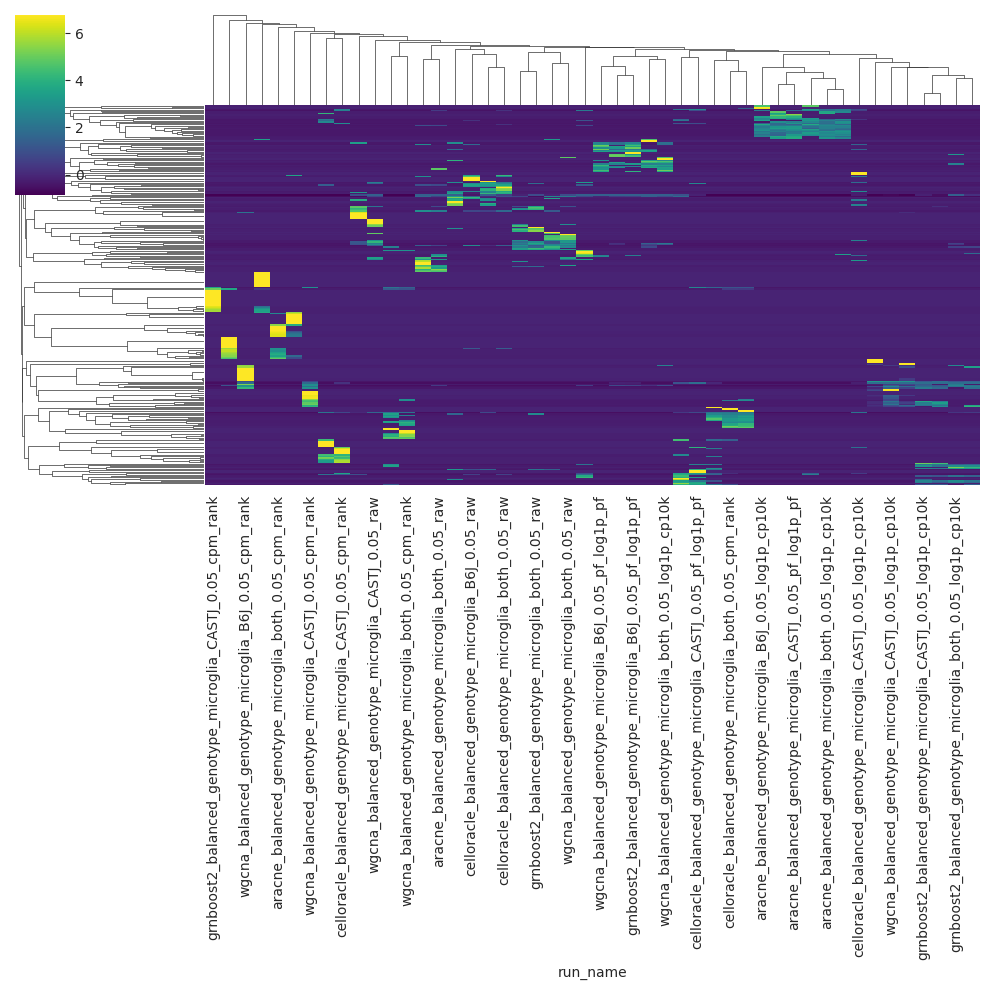

In [116]:
# Clustermap
sns.clustermap(plot_df, cmap="viridis", figsize=(10, 10), row_cluster=True, col_cluster=True, z_score=0, yticklabels=False)

In [86]:
links_dict["aracne_balanced_genotype_microglia_B6J_0.05_cpm_rank"]

,source,target,weight_signed,weight_unsigned,weight_minmax_normalized,p,-logp,description,aracne_regulator_type
0,0,Snx27,NaN,2.997398,0.849920,0.000757,3.12071,NaN,tf
1,1,Ccdc88b,NaN,3.255000,0.925078,0.000757,3.12071,NaN,tf
2,2,Ptprt,NaN,2.629937,0.742708,0.000757,3.12071,NaN,tf
3,3,Phf20l1,NaN,2.428600,0.683966,0.000757,3.12071,NaN,tf
4,4,Polr2a,NaN,3.272600,0.930214,0.000757,3.12071,NaN,tf
...,...,...,...,...,...,...,...,...,...
41591,41591,Vps45,NaN,3.309395,0.940949,0.000757,3.12071,NaN,tf
41592,41592,Csnk1g1,NaN,2.533039,0.714437,0.000757,3.12071,NaN,tf
41593,41593,Dgki,NaN,2.508254,0.707206,0.000757,3.12071,NaN,tf
41594,41594,Grm5,NaN,2.558302,0.721808,0.000757,3.12071,NaN,tf


In [85]:
filtered_links_dict["aracne_balanced_genotype_microglia_B6J_0.05_cpm_rank"]

,source,target,weight_signed,weight_unsigned,weight_minmax_normalized,p,-logp,description,aracne_regulator_type
38520,38520,Jak3,NaN,3.511789,1.000000,7.688635e-10,9.114151,NaN,tf
27578,27578,Gpr165,NaN,3.506275,0.998391,9.761879e-08,7.010467,NaN,tf
39406,39406,Hecw2,NaN,3.478954,0.990420,7.573381e-04,3.120710,NaN,tf
38514,38514,6030468B19Rik,NaN,3.477240,0.989920,9.921888e-06,5.003406,NaN,tf
6678,6678,ENSMUSG00000120580,NaN,3.474614,0.989154,9.921888e-06,5.003406,NaN,tf
...,...,...,...,...,...,...,...,...,...
40580,40580,Insig2,NaN,3.345256,0.951412,7.573381e-04,3.120710,NaN,tf
24611,24611,Tab1,NaN,3.345178,0.951389,7.573381e-04,3.120710,NaN,tf
18686,18686,Elp1,NaN,3.345142,0.951379,7.573381e-04,3.120710,NaN,tf
17458,17458,Tbc1d10a,NaN,3.345097,0.951366,7.573381e-04,3.120710,NaN,tf


# CellOracle

In [71]:
# Make a celloracle links object
links_co = co.Links(name="Bridge_Satpathy_Microglia_balanced_genotype_microglia_comparison", links_dict=links_dict)

In [72]:
# Filter to top 2000 links
links_co.filter_links(weight="weight_unsigned", p=None, threshold_number=2000)

In [74]:
# Calculate network scores.
links_co.get_network_score()

Signature: links_co.get_network_score()
Docstring:
 Get several network sores using igraph library.
 The following scores are calculated: ['degree_all', 'degree_centrality_all', 'degree_in',
'degree_centrality_in', 'degree_out', 'degree_centrality_out',
'betweenness_centrality', 'eigenvector_centrality']

 
File:      ~/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/celloracle/network_analysis/links_object.py
Type:      method

In [ ]:
# Save gene scores for each gene in the network
gene_scores = links_co.merged_score